In [1]:
import tables

from anndata import AnnData
import scanpy.api as sc

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.sparse
import os

import utils as u

In [2]:
%load_ext memory_profiler
%matplotlib inline

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
A = np.random.rand(80000, 2000)
A[A<0.7]=0

size = int(A.nbytes/2**20)
print('~', size, 'MiB')

~ 1220 MiB


In [5]:
AD_dense = AnnData(A)

In [6]:
A = sp.sparse.csr_matrix(A)

size_sparse=int((A.data.nbytes + A.indptr.nbytes + A.indices.nbytes)/2**20)
print('~', size_sparse, 'MiB')

~ 549 MiB


In [7]:
AD_sparse = AnnData(A)

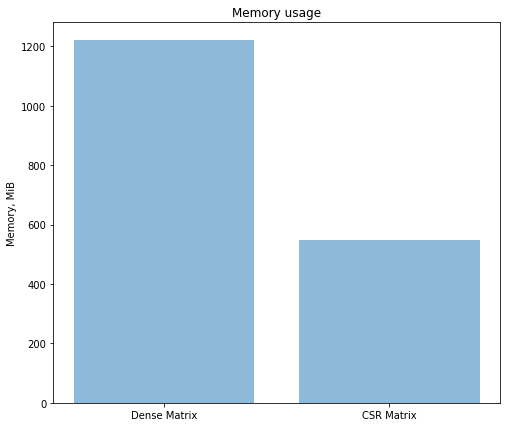

In [8]:
u.simple_bar(('Dense Matrix', 'CSR Matrix'), 'Memory, MiB', 'Memory usage', (size, size_sparse))

Use PCA to test as it uses chunks

In [9]:
timeit_dense = []
timeit_sparse = []

In [10]:
result = %timeit -o -r 3 -n 1 sc.pp.pca(AD_dense, 50)
timeit_dense.append(result.average)

result = %timeit -o -r 3 -n 1 sc.pp.pca(AD_dense, 50, chunked=True)
timeit_dense.append(result.average)

3.2 s ± 98.2 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
41.2 s ± 534 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [11]:
result = %timeit -o -r 3 -n 1 sc.pp.pca(AD_sparse, 50)
timeit_sparse.append(result.average)

result = %timeit -o -r 3 -n 1 sc.pp.pca(AD_sparse, 50, chunked=True)
timeit_sparse.append(result.average)

3.25 s ± 62.3 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
43 s ± 980 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


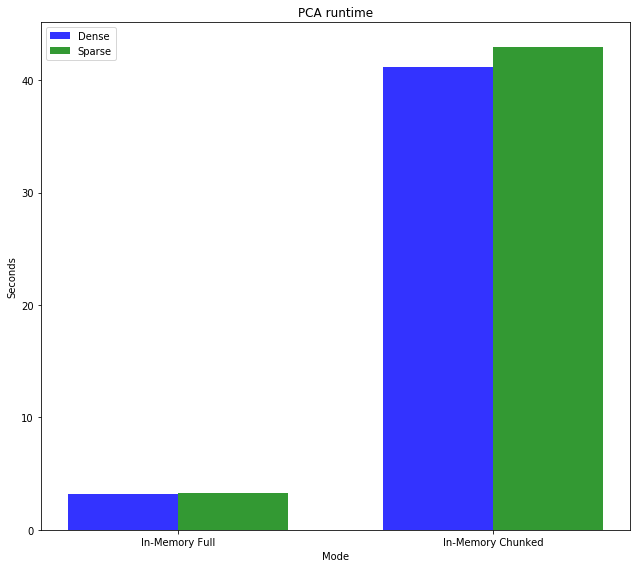

In [12]:
u.plot_groups(('In-Memory Full', 'In-Memory Chunked'), timeit_dense[:2], timeit_sparse[:2], 'Mode', 'Seconds', 'PCA runtime')

In [13]:
memit_dense = []
memit_sparse = []

In [14]:
result = %memit -o sc.pp.pca(AD_dense, 50)
memit_dense.append(max(result.mem_usage)-result.baseline)

result = %memit -o sc.pp.pca(AD_dense, 50, chunked=True)
memit_dense.append(max(result.mem_usage)-result.baseline)

peak memory: 3110.94 MiB, increment: 1224.41 MiB
peak memory: 2322.82 MiB, increment: 432.42 MiB


In [15]:
result = %memit -o sc.pp.pca(AD_sparse, 50)
memit_sparse.append(max(result.mem_usage)-result.baseline)

result = %memit -o sc.pp.pca(AD_sparse, 50, chunked=True)
memit_sparse.append(max(result.mem_usage)-result.baseline)

peak memory: 3740.01 MiB, increment: 1867.58 MiB
peak memory: 2354.47 MiB, increment: 524.57 MiB


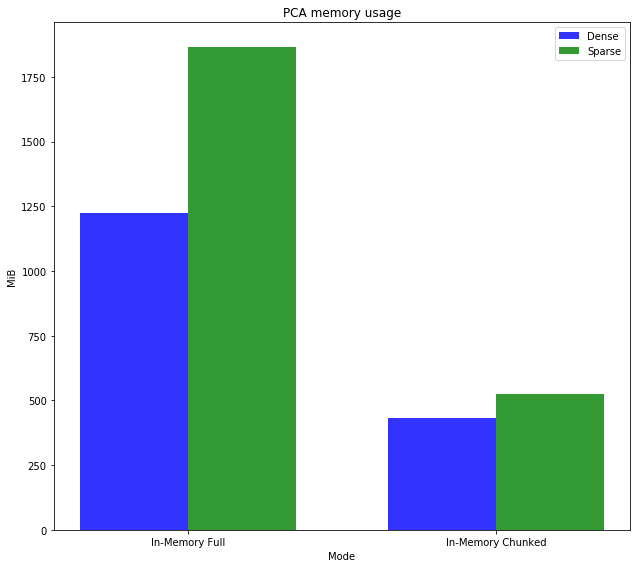

In [16]:
u.plot_groups(('In-Memory Full', 'In-Memory Chunked'), memit_dense, memit_sparse, 'Mode', 'MiB', 'PCA memory usage')

In [17]:
AD_dense_back = AnnData(AD_dense.X)
AD_dense_back.filename = './dense.h5ad'

AD_sparse_back = AnnData(AD_sparse.X)
AD_sparse_back.filename = './sparse.h5ad'

In [18]:
f_sz_dense = int(os.path.getsize('./dense.h5ad')/10**6)
f_sz_sparse = int(os.path.getsize('./sparse.h5ad')/10**6)

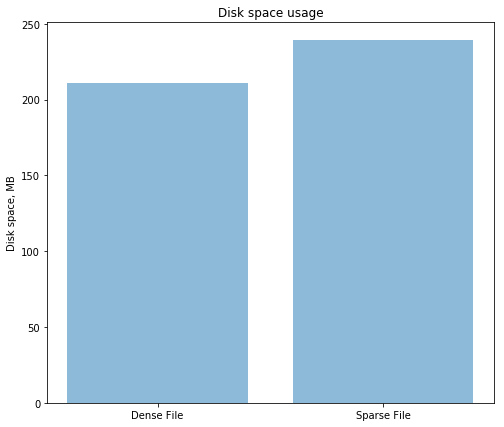

In [19]:
u.simple_bar(('Dense File', 'Sparse File'), 'Disk space, MB', 'Disk space usage', (f_sz_dense, f_sz_sparse))

In [20]:
result = %timeit -o -r 3 -n 1 sc.pp.pca(AD_dense_back, 50)
timeit_dense.append(result.average)

timeit_sparse.append(0)

6.24 s ± 1.18 s per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [21]:
result = %timeit -o -r 3 -n 1 sc.pp.pca(AD_dense_back, 50, chunked=True)
timeit_dense.append(result.average)

result = %timeit -o -r 3 -n 1 sc.pp.pca(AD_sparse_back, 50, chunked=True)
timeit_sparse.append(result.average)

48.3 s ± 545 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
1min 40s ± 1.18 s per loop (mean ± std. dev. of 3 runs, 1 loop each)


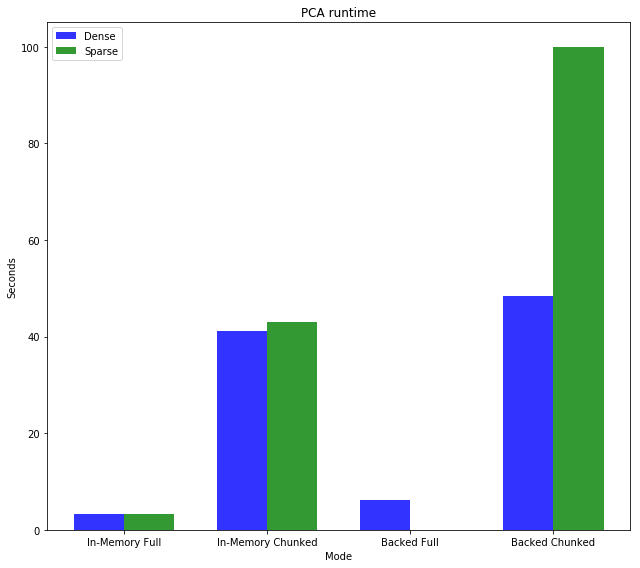

In [22]:
groups = ('In-Memory Full', 'In-Memory Chunked', 'Backed Full', 'Backed Chunked')
u.plot_groups(groups, timeit_dense, timeit_sparse, 'Mode', 'Seconds', 'PCA runtime')

In [23]:
AD_sparse_csc = AnnData(AD_sparse.X.tocsc())

The problem is in looping through rows

In [24]:
chunks_time = []

result = %timeit -o -r 3 -n 1 for _, _, _ in AD_dense.chunked_X(): pass
chunks_time.append(result.average)
result = %timeit -o -r 3 -n 1 for _, _, _ in AD_sparse.chunked_X(): pass
chunks_time.append(result.average)
result = %timeit -o -r 3 -n 1 for _, _, _ in AD_sparse_csc.chunked_X(): pass
chunks_time.append(result.average)
result = %timeit -o -r 3 -n 1 for _, _, _ in AD_dense_back.chunked_X(): pass
chunks_time.append(result.average)
result = %timeit -o -r 3 -n 1 for _, _, _ in AD_sparse_back.chunked_X(): pass
chunks_time.append(result.average)

16 µs ± 6.05 µs per loop (mean ± std. dev. of 3 runs, 1 loop each)
182 ms ± 1.34 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
896 ms ± 15.9 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
3.18 s ± 180 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
27.4 s ± 902 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


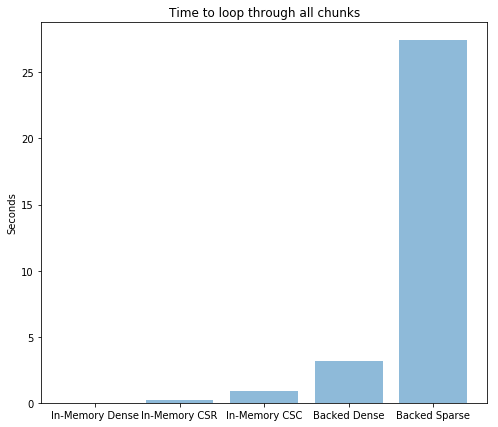

In [25]:
labels = ('In-Memory Dense', 'In-Memory CSR', 'In-Memory CSC', 'Backed Dense', 'Backed Sparse')
u.simple_bar(labels, 'Seconds', 'Time to loop through all chunks', chunks_time)

In [26]:
%memit sc.pp.pca(AD_dense_back, 50, chunked=True)
%memit sc.pp.pca(AD_sparse_back, 50, chunked=True)

peak memory: 2811.11 MiB, increment: 526.98 MiB
peak memory: 2795.79 MiB, increment: 496.45 MiB


In [27]:
AD_dense_back.file.close()
AD_sparse_back.file.close()

del AD_dense_back
del AD_sparse_back

if os.path.isfile('./dense.h5ad'):
    os.remove('./dense.h5ad')
    
if os.path.isfile('./sparse.h5ad'):
    os.remove('./sparse.h5ad')

Use blosc compression

In [28]:
AnnData(AD_dense.X).write('./dense_blosc.h5ad', compression=32001)
AnnData(AD_sparse.X).write('./sparse_blosc.h5ad', compression=32001)

In [29]:
AD_dense_blosc = AnnData(filename='./dense_blosc.h5ad')
AD_sparse_blosc = AnnData(filename='./sparse_blosc.h5ad')

In [30]:
f_sz_dense_blosc = int(os.path.getsize('./dense_blosc.h5ad')/10**6)
f_sz_sparse_blosk = int(os.path.getsize('./sparse_blosc.h5ad')/10**6)

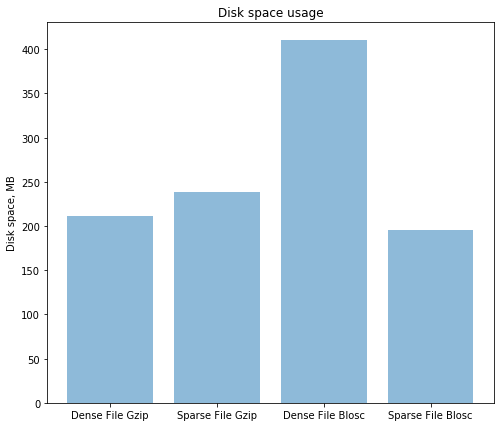

In [31]:
groups = ('Dense File Gzip', 'Sparse File Gzip', 'Dense File Blosc', 'Sparse File Blosc')
u.simple_bar(groups, 'Disk space, MB', 'Disk space usage', (f_sz_dense, f_sz_sparse, f_sz_dense_blosc, f_sz_sparse_blosk))

In [32]:
result = %timeit -o -r 3 -n 1 sc.pp.pca(AD_dense_blosc, 50, chunked=True)
timeit_dense.append(result.average)

result = %timeit -o -r 3 -n 1 sc.pp.pca(AD_sparse_blosc, 50, chunked=True)
timeit_sparse.append(result.average)

50 s ± 3.07 s per loop (mean ± std. dev. of 3 runs, 1 loop each)
50.3 s ± 1.29 s per loop (mean ± std. dev. of 3 runs, 1 loop each)


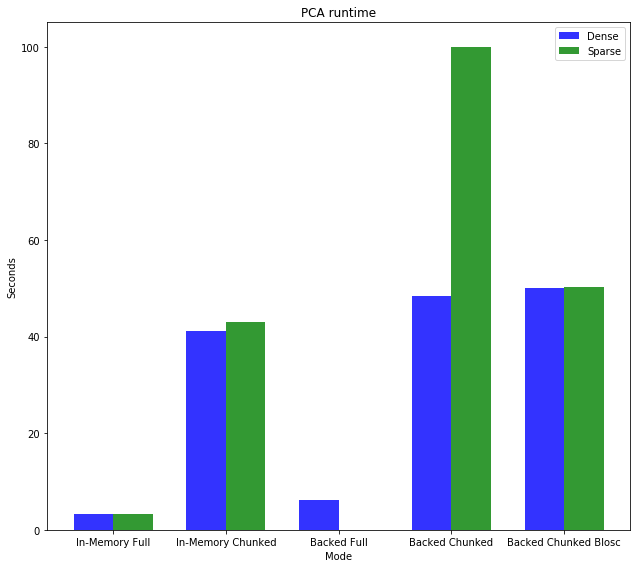

In [33]:
groups = ('In-Memory Full', 'In-Memory Chunked', 'Backed Full', 'Backed Chunked', 'Backed Chunked Blosc')
u.plot_groups(groups, timeit_dense, timeit_sparse, 'Mode', 'Seconds', 'PCA runtime')

In [34]:
result = %timeit -o -r 3 -n 1 for _, _, _ in AD_dense_blosc.chunked_X(): pass
chunks_time.append(result.average)
result = %timeit -o -r 3 -n 1 for _, _, _ in AD_sparse_blosc.chunked_X(): pass
chunks_time.append(result.average)

2.71 s ± 37.8 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
3.86 s ± 54.8 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


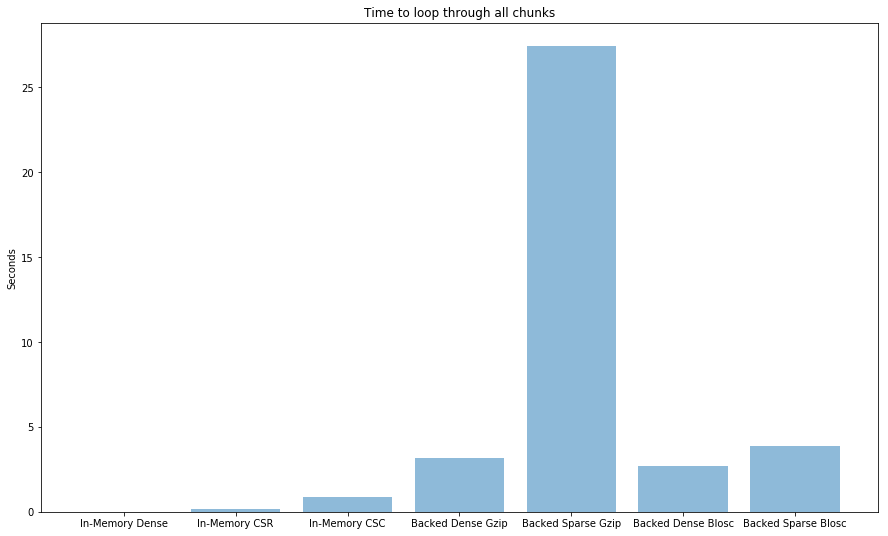

In [35]:
labels = ('In-Memory Dense', 'In-Memory CSR', 'In-Memory CSC', 'Backed Dense Gzip', 'Backed Sparse Gzip', 
          'Backed Dense Blosc', 'Backed Sparse Blosc')
u.simple_bar(labels, 'Seconds', 'Time to loop through all chunks', chunks_time, (15,9))

In [36]:
%memit sc.pp.pca(AD_dense_blosc, 50, chunked=True)
%memit sc.pp.pca(AD_sparse_blosc, 50, chunked=True)

peak memory: 2783.05 MiB, increment: 466.23 MiB
peak memory: 2897.68 MiB, increment: 535.39 MiB


In [37]:
AD_dense_blosc.file.close()
AD_sparse_blosc.file.close()

del AD_dense_blosc
del AD_sparse_blosc

if os.path.isfile('./dense_blosc.h5ad'):
    os.remove('./dense_blosc.h5ad')
    
if os.path.isfile('./sparse_blosc.h5ad'):
    os.remove('./sparse_blosc.h5ad')